In [190]:
#!pip install sweetviz
#!pip install pandas-profiling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime

# Importamos algunas librerías para análisis de datos
import sweetviz as sv

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn import set_config 
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# Ignoraremos los Warnings para hacer el cuaderno un poco más amigable al usuario.
#import warnings
#warnings.filterwarnings("ignore")

# Directory and Version Specification

>Se definiarán variables globales como los directorios desde donde se leen los datos, directorios donde se guardan los resultados y el timestamp para guardar los archivos generados de cada ejecución indiviudal, también se crean los arrays que contienen las variables que no son necesarias y las variables que tienen una combinanción lineal y que se suman en una sola variable para poder expresarlas en una sola variable.

In [191]:
MODEL_TIMESTAMP = datetime.now().strftime("%Y-%m-%d__%H-%M-%S")

DATA_PATH = 'data/'

CONFUSION_MATRIX_PATH = 'confusion_matrix/'
TREE_PATH = 'tree/regression/'

REPORTS_PATH = 'reports/regression/'
SAMPLE_GRAPH_RESULTS_PATH  = 'sample_graph_result/regression/'

# Resolución de imágenes
resolution = 300

# Declaramos algunas variables globales
N_JOBS = 6 # Número de núclos a implementar por gridsearch para el hyper parámeter tuning
CV = 5 # Número de interaciones para hacer cross validation.

# Parámetros de los winners y losers con los que se realizan cálculos y se debn hacer drop.
UNNECESSARY_ATTR = ['tourney_id', 'tourney_name', 'winner_name', 'loser_name', 'winner_entry', 'winner_seed', 'loser_entry', 'loser_seed','tourney_date', 'winner_id', 'loser_id', 'score']
WL_DROP = ['w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms']

MODEL_TIMESTAMP

'2022-05-03__18-07-19'

# Download and Store Data

In [192]:
# for index in range(0,22):
#     index_str = str(index)

#     print(index_str)
    
#     if len(index_str) == 1:
#         index_str = '0' + index_str

#     print(index_str)

#     url = "https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_20{}.csv".format(index_str)
#     print(url)

#     FILE_NAME = "atp_matches_20{}.csv".format(index_str)

#     df = pd.read_csv(url, index_col=0, parse_dates=[0])
#     df.to_csv(DATA_PATH + FILE_NAME)

# # data_frame = pd.read_csv(DATA_PATH + FILE_NAME)

# Load Data

> Aquí cargaremos los datos desde el repositorio, centraremos todos los datasets en uno para poder hacer la limpieza de los datos.

In [193]:
atp = pd.DataFrame()

years_index_20_22 = range(0,22)

for index in years_index_20_22:
    index_str = str(index)

    if len(index_str) == 1:
        index_str = '0' + index_str

    FILE_NAME = "atp_matches_20{}.csv".format(index_str)

    data_frame_iter = pd.read_csv(DATA_PATH + FILE_NAME)
    atp = pd.concat([atp, data_frame_iter])

# Mostramos todas las columnas, con este comando evitamos que se oculten cuando son muchas.
pd.set_option('display.max_columns', None) 
atp

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2000-301,Auckland,Hard,32,A,20000110,1,103163,1.0,NaN,Tommy Haas,R,188.0,GER,21.771389,101543,NaN,NaN,Jeff Tarango,L,180.0,USA,31.137577,7-5 4-6 7-5,3,R32,108.0,18.0,4.0,96.0,49.0,39.0,28.0,17.0,3.0,5.0,7.0,8.0,106.0,55.0,39.0,29.0,17.0,4.0,7.0,11.0,1612.0,63.0,595.0
1,2000-301,Auckland,Hard,32,A,20000110,2,102607,NaN,Q,Juan Balcells,R,190.0,ESP,24.558522,102644,NaN,NaN,Franco Squillari,L,183.0,ARG,24.386037,7-5 7-5,3,R32,85.0,5.0,3.0,76.0,52.0,39.0,13.0,12.0,5.0,6.0,5.0,10.0,74.0,32.0,25.0,18.0,12.0,3.0,6.0,211.0,157.0,49.0,723.0
2,2000-301,Auckland,Hard,32,A,20000110,3,103252,NaN,NaN,Alberto Martin,R,175.0,ESP,21.390828,102238,NaN,NaN,Alberto Berasategui,R,173.0,ESP,26.535250,6-3 6-1,3,R32,56.0,0.0,0.0,55.0,35.0,25.0,12.0,8.0,1.0,1.0,0.0,6.0,56.0,33.0,20.0,7.0,8.0,7.0,11.0,48.0,726.0,59.0,649.0
3,2000-301,Auckland,Hard,32,A,20000110,4,103507,7.0,NaN,Juan Carlos Ferrero,R,183.0,ESP,19.909651,103819,NaN,NaN,Roger Federer,R,185.0,SUI,18.422998,6-4 6-4,3,R32,68.0,5.0,1.0,53.0,28.0,26.0,15.0,10.0,0.0,0.0,11.0,2.0,70.0,43.0,29.0,14.0,10.0,6.0,8.0,45.0,768.0,61.0,616.0
4,2000-301,Auckland,Hard,32,A,20000110,5,102103,NaN,Q,Michael Sell,R,180.0,USA,27.381246,102765,4.0,NaN,Nicolas Escude,R,185.0,FRA,23.770021,0-6 7-6(7) 6-1,3,R32,115.0,1.0,2.0,98.0,66.0,39.0,14.0,13.0,6.0,11.0,8.0,8.0,92.0,46.0,34.0,18.0,12.0,5.0,9.0,167.0,219.0,34.0,873.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2722,2021-M-DC-2021-WG2-M-THA-DEN-01,Davis Cup WG2 R1: THA vs DEN,Hard,4,D,20210917,4,200416,NaN,NaN,August Holmgren,R,NaN,DEN,23.394935,106397,NaN,NaN,Wishaya Trongcharoenchaikul,R,NaN,THA,26.433949,6-4 6-4,3,RR,90.0,3.0,3.0,52.0,29.0,22.0,16.0,10.0,0.0,1.0,8.0,2.0,79.0,45.0,30.0,14.0,10.0,10.0,13.0,905.0,16.0,767.0,27.0
2723,2021-M-DC-2021-WG2-M-THA-DEN-01,Davis Cup WG2 R1: THA vs DEN,Hard,4,D,20210917,5,208937,NaN,NaN,Kasidit Samrej,R,NaN,THA,20.629706,134087,NaN,NaN,Johannes Ingildsen,R,NaN,DEN,24.202601,7-5 6-3,3,RR,88.0,6.0,6.0,58.0,28.0,21.0,13.0,11.0,3.0,7.0,5.0,8.0,76.0,43.0,24.0,13.0,10.0,5.0,11.0,1136.0,8.0,1546.0,2.0
2724,2021-M-DC-2021-WG2-M-TUR-LAT-01,Davis Cup WG2 R1: TUR vs LAT,Hard,4,D,20210918,1,123795,NaN,NaN,Altug Celikbilek,U,NaN,TUR,25.015743,207669,NaN,NaN,Robert Strombachs,U,NaN,GER,21.995893,7-6(4) 6-4,3,RR,124.0,6.0,8.0,80.0,34.0,25.0,23.0,11.0,6.0,8.0,3.0,5.0,97.0,50.0,34.0,20.0,11.0,6.0,9.0,170.0,427.0,671.0,38.0
2725,2021-M-DC-2021-WG2-M-TUR-LAT-01,Davis Cup WG2 R1: TUR vs LAT,Hard,4,D,20210918,2,117356,NaN,NaN,Cem Ilkel,R,185.0,TUR,26.064339,105208,NaN,NaN,Ernests Gulbis,R,190.0,LAT,33.037645,6-4 6-1,3,RR,65.0,2.0,2.0,41.0,27.0,23.0,7.0,9.0,0.0,1.0,1.0,5.0,45.0,21.0,16.0,7.0,8.0,2.0,7.0,176.0,408.0,196.0,359.0


In [194]:
atp[atp['winner_name'] == 'Novak Djokovic']

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
2783,2004-773,Bucharest,Clay,32,A,20040913,14,104925,NaN,Q,Novak Djokovic,R,188.0,SRB,17.314168,103096,NaN,NaN,Arnaud Clement,R,173.0,FRA,26.740589,2-6 6-4 6-4,3,R32,146.0,4.0,2.0,91.0,60.0,39.0,19.0,14.0,2.0,5.0,0.0,2.0,93.0,62.0,40.0,16.0,14.0,7.0,10.0,272.0,128.0,67.0,623.0
3133,2004-D045,Davis Cup G2 R1: SCG vs LAT,Carpet,4,D,20040409,5,104925,NaN,NaN,Novak Djokovic,R,188.0,SRB,16.873374,108912,NaN,NaN,Janis Skroderis,R,NaN,LAT,20.643395,6-2 6-2,3,RR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,606.0,28.0,1340.0,2.0
728,2005-352,Paris Masters,Carpet,48,M,20051031,5,104925,NaN,Q,Novak Djokovic,R,188.0,SRB,18.444901,103812,NaN,NaN,Victor Hanescu,R,198.0,ROU,24.279261,4-1 RET,3,R64,19.0,1.0,1.0,12.0,8.0,6.0,2.0,2.0,0.0,0.0,0.0,1.0,20.0,12.0,8.0,1.0,3.0,3.0,5.0,85.0,488.0,37.0,853.0
744,2005-352,Paris Masters,Carpet,48,M,20051031,21,104925,NaN,Q,Novak Djokovic,R,188.0,SRB,18.444901,103264,4.0,NaN,Mariano Puerta,L,180.0,ARG,27.115674,6-3 7-6(9),3,R32,105.0,12.0,2.0,82.0,51.0,38.0,19.0,11.0,4.0,5.0,4.0,2.0,74.0,49.0,34.0,12.0,10.0,6.0,8.0,85.0,488.0,9.0,1834.0
816,2005-375,Lyon,Carpet,32,A,20051024,15,104925,NaN,NaN,Novak Djokovic,R,188.0,SRB,18.425736,103672,NaN,NaN,Ricardo Mello,L,175.0,BRA,24.840520,7-6(5) 6-4,3,R32,105.0,4.0,3.0,80.0,51.0,37.0,12.0,11.0,5.0,7.0,5.0,5.0,90.0,65.0,38.0,14.0,11.0,6.0,9.0,88.0,468.0,105.0,398.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2570,2021-9512,Belgrade 2,Clay,32,A,20210524,300,104925,1.0,NaN,Novak Djokovic,R,188.0,SRB,34.006845,144684,NaN,Q,Alex Molcan,L,NaN,SVK,23.477070,6-4 6-3,3,F,88.0,2.0,3.0,49.0,27.0,19.0,10.0,10.0,1.0,5.0,1.0,0.0,62.0,36.0,19.0,9.0,9.0,2.0,8.0,1.0,11063.0,255.0,237.0
2631,2021-M-DC-2021-FLS-F-M-SRB-AUT-01,Davis Cup Finals RR: SRB vs AUT,Hard,2,D,20211126,2,104925,NaN,NaN,Novak Djokovic,R,188.0,SRB,34.505133,110602,NaN,NaN,Dennis Novak,R,183.0,AUT,28.235455,6-3 6-2,3,RR,57.0,3.0,0.0,42.0,26.0,22.0,14.0,9.0,0.0,0.0,2.0,0.0,45.0,31.0,18.0,8.0,8.0,2.0,5.0,1.0,11540.0,118.0,621.0
2633,2021-M-DC-2021-FLS-F-M-SRB-GER-01,Davis Cup Finals RR: SRB vs GER,Hard,2,D,20211127,2,104925,NaN,NaN,Novak Djokovic,R,188.0,SRB,34.505133,105526,NaN,NaN,Jan Lennard Struff,R,193.0,GER,31.578371,6-2 6-4,3,RR,72.0,9.0,0.0,52.0,34.0,27.0,11.0,9.0,0.0,0.0,2.0,1.0,58.0,38.0,23.0,9.0,9.0,3.0,6.0,1.0,11540.0,51.0,1134.0
2635,2021-M-DC-2021-FLS-M-CRO-SRB-01,Davis Cup Finals SF: CRO vs SRB,Hard,2,D,20211203,2,104925,NaN,NaN,Novak Djokovic,R,188.0,SRB,34.524298,105227,NaN,NaN,Marin Cilic,R,198.0,CRO,33.169062,6-4 6-2,3,RR,99.0,4.0,1.0,60.0,40.0,30.0,12.0,9.0,8.0,8.0,6.0,3.0,66.0,37.0,23.0,13.0,9.0,5.0,8.0,1.0,11540.0,30.0,1710.0


In [195]:
df = atp 

print('=================================================================')
print(df.info())
print('=================================================================')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65894 entries, 0 to 2726
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tourney_id          65894 non-null  object 
 1   tourney_name        65894 non-null  object 
 2   surface             65894 non-null  object 
 3   draw_size           65894 non-null  int64  
 4   tourney_level       65894 non-null  object 
 5   tourney_date        65894 non-null  int64  
 6   match_num           65894 non-null  int64  
 7   winner_id           65894 non-null  int64  
 8   winner_seed         27355 non-null  float64
 9   winner_entry        8128 non-null   object 
 10  winner_name         65894 non-null  object 
 11  winner_hand         65885 non-null  object 
 12  winner_ht           63258 non-null  float64
 13  winner_ioc          65894 non-null  object 
 14  winner_age          65891 non-null  float64
 15  loser_id            65894 non-null  int64  
 16  loser

In [196]:
atp_report = sv.analyze(df)
atp_report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Clean Dataset

> Haremos un análisis de correlación de las variables que utilizaremos para la regresión, 
con la regresión intentaremos estimar la variable respuesta **minutes** que es la caracteristica que describe 
el tiempo de duración de un partido. 

> También haremos una limpieza de los datos que necesitamos, quitaremos algunas caracteristicas que no aportan información al análisis de regresión, quitaremos algunos identificadores.

> Del análisis con Sweetviz hemos encontrado que para la variable a predeir **"minutes"** tenemos algunos outliers, para esto revisaremos el record de los partidos de tennis más extensos. 

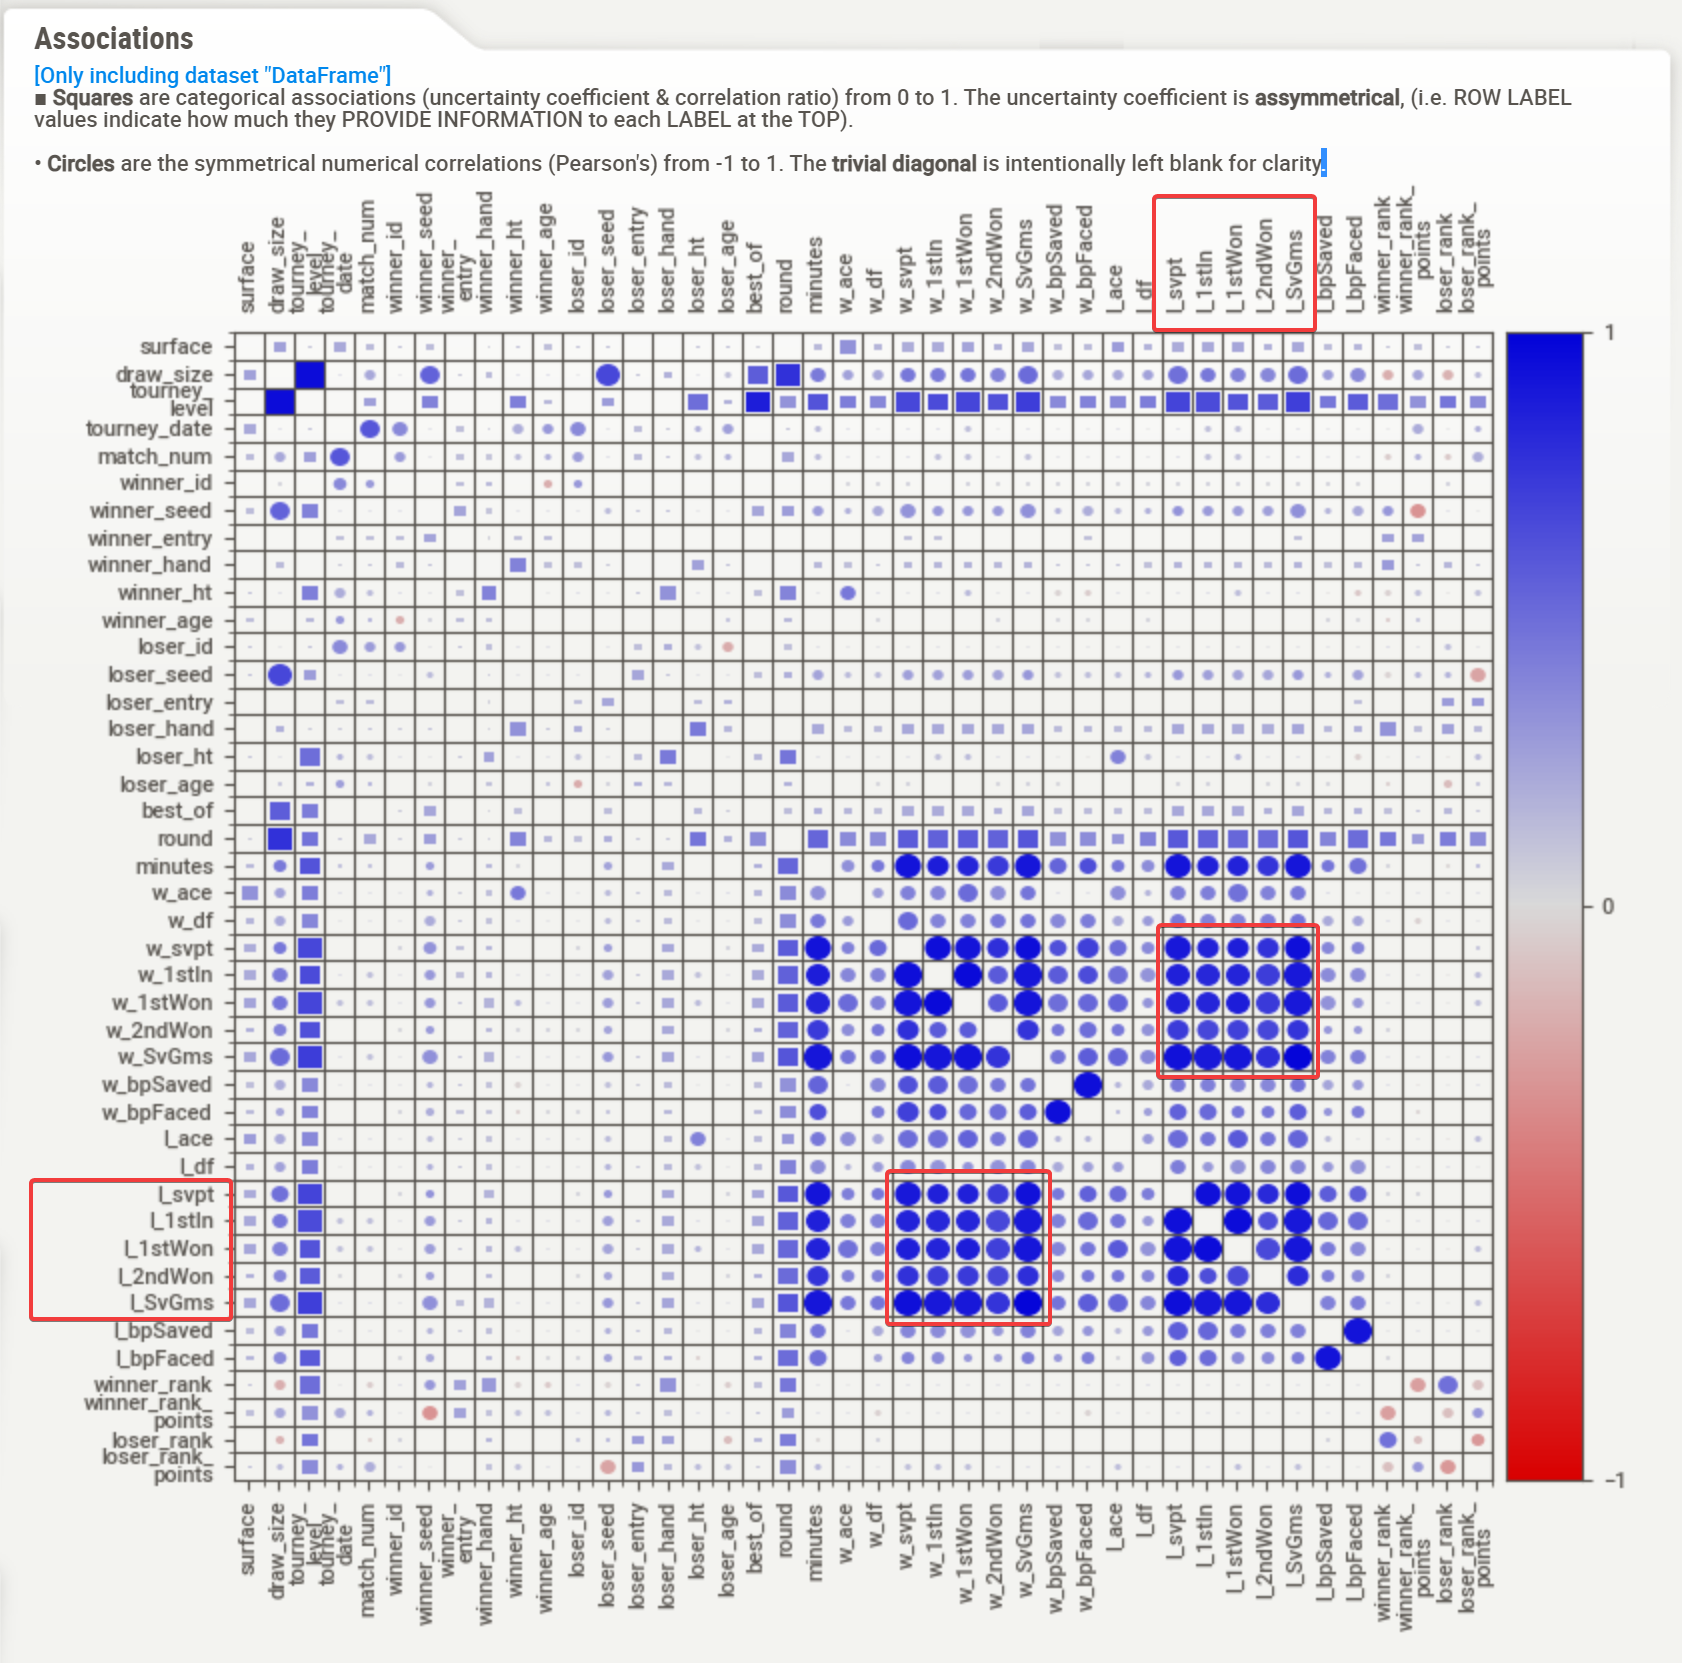

> Podemos observar en la gráfica de correlación de las características del dataset, hay una fuerte correlación entre las variables relacionadas con atributos del perdedor y los atributos del ganador.

> Para tratar con esta fuerte correlación entre los atributos **w_svpt, w_1stIn, w_1stWon, w_2ndWon, w_SvGms** que están relacionados con las estadísticas de los ganadores y los atributos **l_svpt, l_1stIn, l_1stWon, l_2ndWon, l_SvGms** que están relacionados con las estadísticas de los perdedores.

## Outliers Analysis

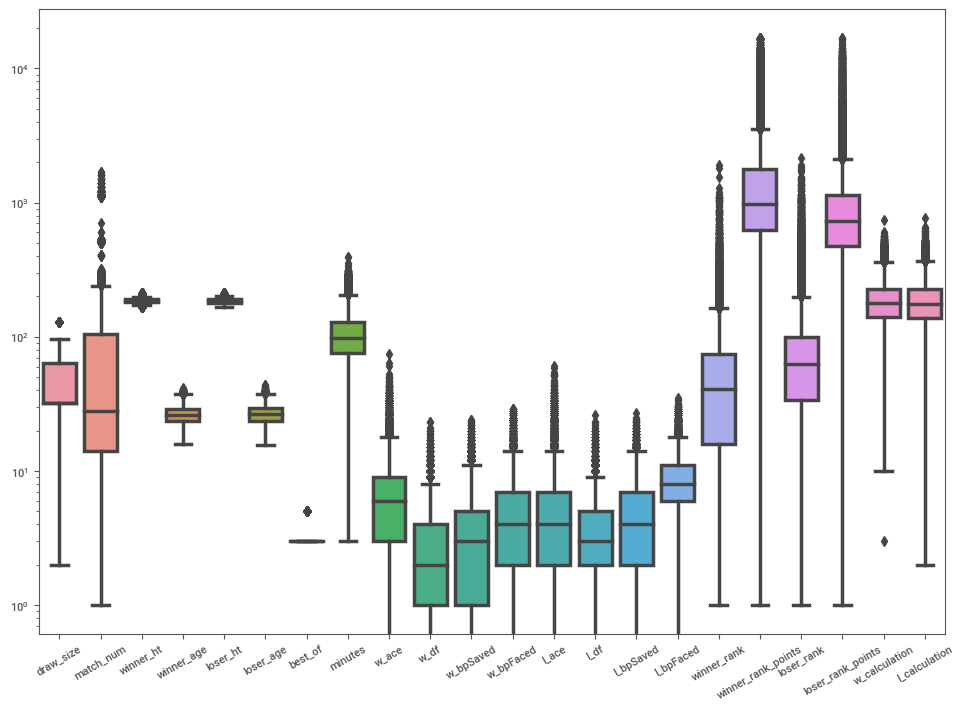

In [197]:
df_out = df_regression.copy()
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
g = sns.boxplot(data = df_out, linewidth = 2.5, ax = ax)
g.set_yscale("log")

## Sweetviz Report after Data Cleaning and Manipulation

Sweetviz es una biblioteca Python de código abierto que genera visualizaciones de alta densidad para iniciar EDA (Análisis exploratorio de datos) con solo dos líneas de código. Output es una aplicación HTML completamente autónoma.

> De los outliers el que más nos interesa es el de `minutes`, para este caso se han analizado el record de [Longest Tennis Match Records](https://en.wikipedia.org/wiki/Longest_tennis_match_records)

In [198]:
# Vamos a eliminar las variables que son identificadores, nombres etc
# Incluimos en el drop las siguientes variables que tienen muchos registros NaN
df_regression = df


df_regression = df_regression.drop(UNNECESSARY_ATTR, axis = 1) 
df_regression = df_regression.dropna()
df_regression = df_regression.drop_duplicates()

# Crearemos dos formulas para calculos del ganador y el perdedor para evitar la correlación de estas variables, tambien haremos un drop de estas variables.
df_regression['w_calculation'] = df_regression['w_svpt'] + df_regression['w_1stIn'] + df_regression['w_1stWon'] + df_regression['w_2ndWon'] + df_regression['w_SvGms']
df_regression['l_calculation'] = df_regression['l_svpt'] + df_regression['l_1stIn'] + df_regression['l_1stWon'] + df_regression['l_2ndWon'] + df_regression['l_SvGms']

df_regression = df_regression.drop(WL_DROP, axis = 1) 

df_regression = df_regression._get_numeric_data() #drop non-numeric cols

# Eliminamos los outlier para minutes, se investigó los partidos más extensos de la historia del tennis y ninguno duró mas de 
# 660 minutos según el record mundial de los partidos de tennis más largos.
df_regression = df_regression[df_regression['minutes'] < 400]

atp_report = sv.analyze(df_regression)
atp_report.show_html()
df_regression.info()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 54903 entries, 0 to 2725
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   draw_size           54903 non-null  int64  
 1   match_num           54903 non-null  int64  
 2   winner_ht           54903 non-null  float64
 3   winner_age          54903 non-null  float64
 4   loser_ht            54903 non-null  float64
 5   loser_age           54903 non-null  float64
 6   best_of             54903 non-null  int64  
 7   minutes             54903 non-null  float64
 8   w_ace               54903 non-null  float64
 9   w_df                54903 non-null  float64
 10  w_bpSaved           54903 non-null  float64
 11  w_bpFaced           54903 non-null  float64
 12  l_ace               54903 non-null  float6

**Atributos Utilizados para la Regresión**

El objetivo de utilizar Decission Regressor Tree es poder entrenar un modelo que permita poder predecir el tiempo de una partida de Tennis. Para poder elaborar este modelo necesitamos usar las caracteristicas que consideremos, previo a un análisis, como las más importantes y las que mejor puedan ayudar a predecir nuestra variable respuesta **minutes**.

A continuación analizaremos los campos de importancia que se utilizarán en este proyecto de cara a los experimentos con el **Decission Tree Regressor**:

- `draw_size` : el calendario de partidos en un torneo de tenis. Los encuentros iniciales están determinados por un proceso combinado de clasificación de jugadores y selección aleatoria, y pueden o no involucrar una ceremonia de sorteo público. Se establece un sorteo de clasificación para organizar la alineación inicial de la competencia clasificatoria (clasificatorias), desde donde los jugadores no cabezas de serie califican para un lugar en la alineación inicial o el cuadro principal del torneo.
- `match_num` : número de enfrentamientos entre dos jugadores (partido de individuales) o dos equipos de jugadores (partido de dobles), normalmente jugado al mejor de tres o cinco sets.
- `winner_ht, loser_ht`: altura del jugador ganador y del perdedor respectivamente.
- `winner_age, loser_age` : edad en años del ganador y el perdedor respectivamente.
- `best_of` : En tennis que el ganador de una serie de juegos, sets, etc. será el que gane la mayoría del número impar (tres, cinco, siete, etc.) máximo a jugar.
- `minutes`: número de minutos transcurridos en el partido.
- `w_ace, l_ace`: número de aces (saques directos) del ganador y del perdedor respectivamente.
- `w_df, l_df` : número de dobles faltas del ganador y del perdedor respectivamente.
- `w_bpSaved, l_bpSaved`: número puntos de rotura de servicio (break points) que ha neutralizado el ganador y el perdedor respectivamente.
- `w_bpFaced, l_bpFaced`: número puntos de rotura de servicio (break points) que han surfido el ganador y el perdedor respectivamente.
- `winner_rank, loser_rank` : posición en el ranking de la ATP del ganador y el perdedor.
- `winner_rank_points, loser_rank_points`: número de puntos en el ranking de la ATP del ganador y el perdedor.
- `w_calculation` : atributo que es una suma de los campos `w_svpt`, `w_1stIn`, `w_1stWon`, `w_2ndWon` y `w_SvGms` cuyo propósito es evitar la fuerte correlación con otras atributos del perdedor.
- `l_calculation` : atributo que es una suma de los campos `l_svpt`, `l_1stIn`, `l_1stWon`, `l_2ndWon` y `l_SvGms` cuyo propósito es evitar la fuerte correlación con otras atributos del ganador.


# Aplicando Decission Tree Regressor con Hyper Parameter Tuning

> Aplicaremos DTR sobre el conjunto de datos limpio, divideremos previamente el conjunto de datos entre entrenamiento y test.

## MinMaxScaler

Transforme las funciones escalando cada función a un rango determinado.

Este estimador escala y traduce cada característica individualmente de modo que esté en el rango dado en el conjunto de entrenamiento, por ejemplo: entre cero y uno.

In [199]:
MODEL_NAME = 'minmaxscaler'

X = df_regression.drop('minutes', axis = 1) 
y = df_regression['minutes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 2)

In [200]:
set_config(print_changed_only=False) 

dtr_pipe = Pipeline([('mms', MinMaxScaler()),
                     ('dtr', DecisionTreeRegressor(random_state = 2))])

params = [{#'dtr__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
         #'dtr__splitter': ['best', 'random'],
         'dtr__max_features': [None],
         #'dtr__max_depth': [1, 3, 5, 7],
         'dtr__min_weight_fraction_leaf': [0.0, 0.1, 0,2]}]

gs_dtr = GridSearchCV(dtr_pipe,
                      param_grid = params,
                      scoring = 'explained_variance',
                      n_jobs = N_JOBS,
                      cv = CV)

gs_dtr.fit(X_train, y_train)
print(f'Los parámetros del mejor modelo son: {gs_dtr.best_params_}')

print(f'El score con el conjunto de entrenamiento de los mejores parámetros es: {gs_dtr.score(X_train, y_train)}')
print(f'El score con el conjunto de test de los mejores parámetros es: {gs_dtr.score(X_test, y_test)}')

Los parámetros del mejor modelo son: {'dtr__max_features': None, 'dtr__min_weight_fraction_leaf': 0.1}
El score con el conjunto de entrenamiento de los mejores parámetros es: 0.7946554748395886
El score con el conjunto de test de los mejores parámetros es: 0.7949525398325576


In [201]:
y_pred = gs_dtr.predict(X_test)#dtr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)
print("MSE: ", mse)
print("RMSE: ", rmse)

score = gs_dtr.score(X_test, y_test)#dtr.score(X_test, y_test)
print("Score:", score) 

MSE:  331.9997081527093
RMSE:  18.220859149686362
Score: 0.7949525398325576


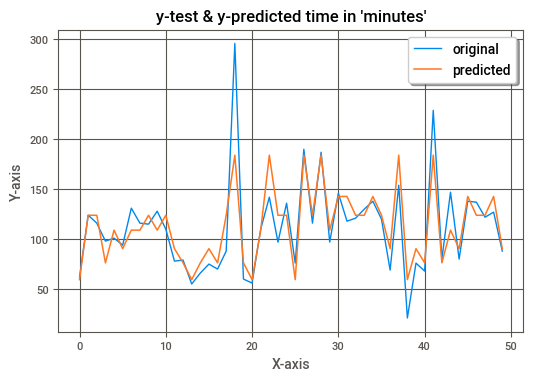

In [202]:
x_ax = range(len(y_test[:50]))
plt.plot(x_ax, y_test[:50], linewidth=1, label="original")
plt.plot(x_ax, y_pred[:50], linewidth=1.1, label="predicted")
plt.title("y-test & y-predicted time in 'minutes'")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)

GRAPH_PATH = f"{SAMPLE_GRAPH_RESULTS_PATH}"
FILE_NAME  = f"{MODEL_NAME}_{MODEL_TIMESTAMP}.png"

plt.grid(True)
plt.savefig(GRAPH_PATH + FILE_NAME, dpi = 100)
plt.show()

## StandardScaler

Este escalador estandariza las características eliminando la media y escalando a la varianza de la unidad.

In [203]:
MODEL_NAME = 'standarscaler'

X = df_regression.drop('minutes', axis = 1) 
y = df_regression['minutes']

# Comentaremos este escalado de datos y lo haremos probando el MinMaxScaler, RobustScaler y el StandarScaler
#X = scale(X)
#y = scale(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 2)

In [204]:
set_config(print_changed_only=False) 

dtr_pipe = Pipeline([('ss', StandardScaler()),
                     ('dtr', DecisionTreeRegressor(random_state = 2))])

params = [{#'dtr__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
         #'dtr__splitter': ['best', 'random'],
         'dtr__max_features': [None],
         #'dtr__max_depth': [1, 3, 5, 7],
         'dtr__min_weight_fraction_leaf': [0.0, 0.1, 0,2]}]

gs_dtr = GridSearchCV(dtr_pipe,
                      param_grid = params,
                      scoring = 'explained_variance',
                      n_jobs = N_JOBS,
                      cv = CV)

gs_dtr.fit(X_train, y_train)
print(f'Los parámetros del mejor modelo son: {gs_dtr.best_params_}')

print(f'El score con el conjunto de entrenamiento de los mejores parámetros es: {gs_dtr.score(X_train, y_train)}')
print(f'El score con el conjunto de test de los mejores parámetros es: {gs_dtr.score(X_test, y_test)}')
#==========================================================================
#dtr.fit(X_train, y_train)

#score = dtr.score(X_train, y_train)
#print("R-squared:", score) set_config(print_changed_only=False) 

Los parámetros del mejor modelo son: {'dtr__max_features': None, 'dtr__min_weight_fraction_leaf': 0.1}
El score con el conjunto de entrenamiento de los mejores parámetros es: 0.7946554748395886
El score con el conjunto de test de los mejores parámetros es: 0.7949525398325576


In [205]:
y_pred = gs_dtr.predict(X_test)#dtr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)
print("MSE: ", mse)
print("RMSE: ", rmse)

score = gs_dtr.score(X_test, y_test)#dtr.score(X_test, y_test)
print("Score: ", score) 

MSE:  331.9997081527093
RMSE:  18.220859149686362
Score:  0.7949525398325576


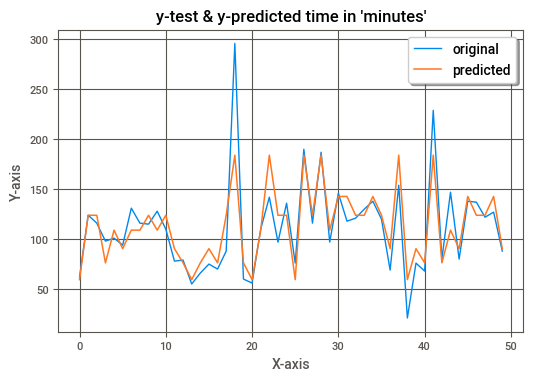

In [206]:
x_ax = range(len(y_test[:50]))
plt.plot(x_ax, y_test[:50], linewidth=1, label="original")
plt.plot(x_ax, y_pred[:50], linewidth=1.1, label="predicted")
plt.title("y-test & y-predicted time in 'minutes'")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)

GRAPH_PATH = f"{SAMPLE_GRAPH_RESULTS_PATH}"
FILE_NAME  = f"{MODEL_NAME}_{MODEL_TIMESTAMP}.png"

plt.grid(True)
plt.savefig(GRAPH_PATH + FILE_NAME, dpi = 100)
plt.show()

## RobustScaler

In [207]:
MODEL_NAME = 'robustscaler'

X = df_regression.drop('minutes', axis = 1) 
y = df_regression['minutes']

# Comentaremos este escalado de datos y lo haremos probando el MinMaxScaler, RobustScaler y el StandarScaler
#X = scale(X)
#y = scale(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 2)

In [208]:
set_config(print_changed_only = False) 

dtr_pipe = Pipeline([('rs', RobustScaler()),
                     ('dtr', DecisionTreeRegressor(random_state = 2))])

params = [{#'dtr__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
         #'dtr__splitter': ['best', 'random'],
         'dtr__max_features': [None],
         #'dtr__max_depth': [1, 3, 5, 7],
         'dtr__min_weight_fraction_leaf': [0.0, 0.1, 0,2]}]

gs_dtr = GridSearchCV(dtr_pipe,
                      param_grid = params,
                      scoring = 'explained_variance',
                      n_jobs = N_JOBS,
                      cv = CV)

gs_dtr.fit(X_train, y_train)
print(f'Los parámetros del mejor modelo son: {gs_dtr.best_params_}')

print(f'El score con el conjunto de entrenamiento de los mejores parámetros es: {gs_dtr.score(X_train, y_train)}')
print(f'El score con el conjunto de test de los mejores parámetros es: {gs_dtr.score(X_test, y_test)}')

Los parámetros del mejor modelo son: {'dtr__max_features': None, 'dtr__min_weight_fraction_leaf': 0.1}
El score con el conjunto de entrenamiento de los mejores parámetros es: 0.7946554748395886
El score con el conjunto de test de los mejores parámetros es: 0.7949525398325576


In [209]:
y_pred = gs_dtr.predict(X_test)#dtr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)
print("MSE: ", mse)
print("RMSE: ", rmse)

score = gs_dtr.score(X_test, y_test)
print(f"Score: {score}") 

MSE:  331.9997081527093
RMSE:  18.220859149686362
Score: 0.7949525398325576


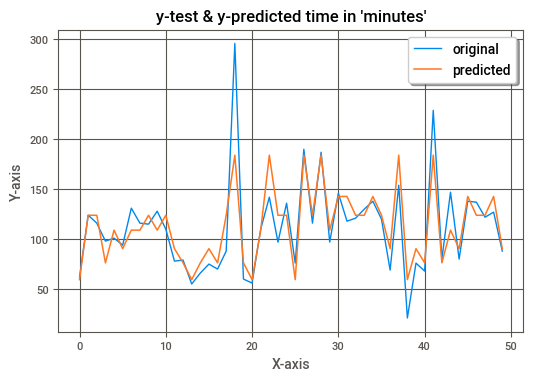

In [210]:
x_ax = range(len(y_test[:50]))
plt.plot(x_ax, y_test[:50], linewidth=1, label="original")
plt.plot(x_ax, y_pred[:50], linewidth=1.1, label="predicted")
plt.title("y-test & y-predicted time in 'minutes'")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)

GRAPH_PATH = f"{SAMPLE_GRAPH_RESULTS_PATH}"
FILE_NAME  = f"{MODEL_NAME}_{MODEL_TIMESTAMP}.png"

plt.grid(True)
plt.savefig(GRAPH_PATH + FILE_NAME, dpi = 100)
plt.show()

# Aplicando Decission Tree Regressor con parámetros seleccionados de Hyper Parameter Tuning

## Pintar el arbol

## Guardar los parámetros de MSE RMSE y Score y mostrarlos en una tablita

DecisionTreeRegressor(ccp_alpha=0.0, criterion='absolute_error', max_depth=7,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      random_state=2, splitter='best')
R-squared: 0.885845404903622
MSE:  189.02900464438576
RMSE:  13.748781933116321
Score: 0.8817252791866323


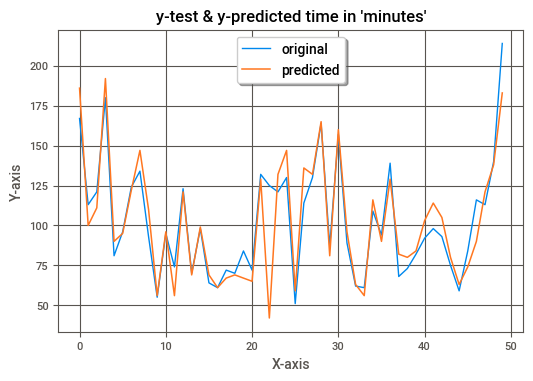

In [211]:
MODEL_NAME = 'best_hyper_params'
X = df_regression.drop('minutes', axis = 1) 
y = df_regression['minutes']

# Comentaremos este escalado de datos y lo haremos probando el MinMaxScaler, RobustScaler y el StandarScaler
#X = scale(X)
#y = scale(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

dtr = DecisionTreeRegressor(criterion ='absolute_error', 
                      max_depth = 7,
                      max_features = None, 
                      min_weight_fraction_leaf = 0.0,
                      random_state = 2, 
                      splitter = 'best') 

print(dtr)
 

dtr.fit(X_train, y_train)

score = dtr.score(X_train, y_train)
print("R-squared:", score) 

y_pred = dtr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)
print("MSE: ", mse)
print("RMSE: ", rmse)

score = dtr.score(X_test, y_test)
print(f"Score: {score}") 

x_ax = range(len(y_test[:50]))
plt.plot(x_ax, y_test[:50], linewidth=1, label="original")
plt.plot(x_ax, y_pred[:50], linewidth=1.1, label="predicted")
plt.title("y-test & y-predicted time in 'minutes'")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)

GRAPH_PATH = f"{SAMPLE_GRAPH_RESULTS_PATH}"
FILE_NAME  = f"{MODEL_NAME}_{MODEL_TIMESTAMP}.png"

plt.grid(True)
plt.savefig(GRAPH_PATH + FILE_NAME, dpi = 100)
plt.show()

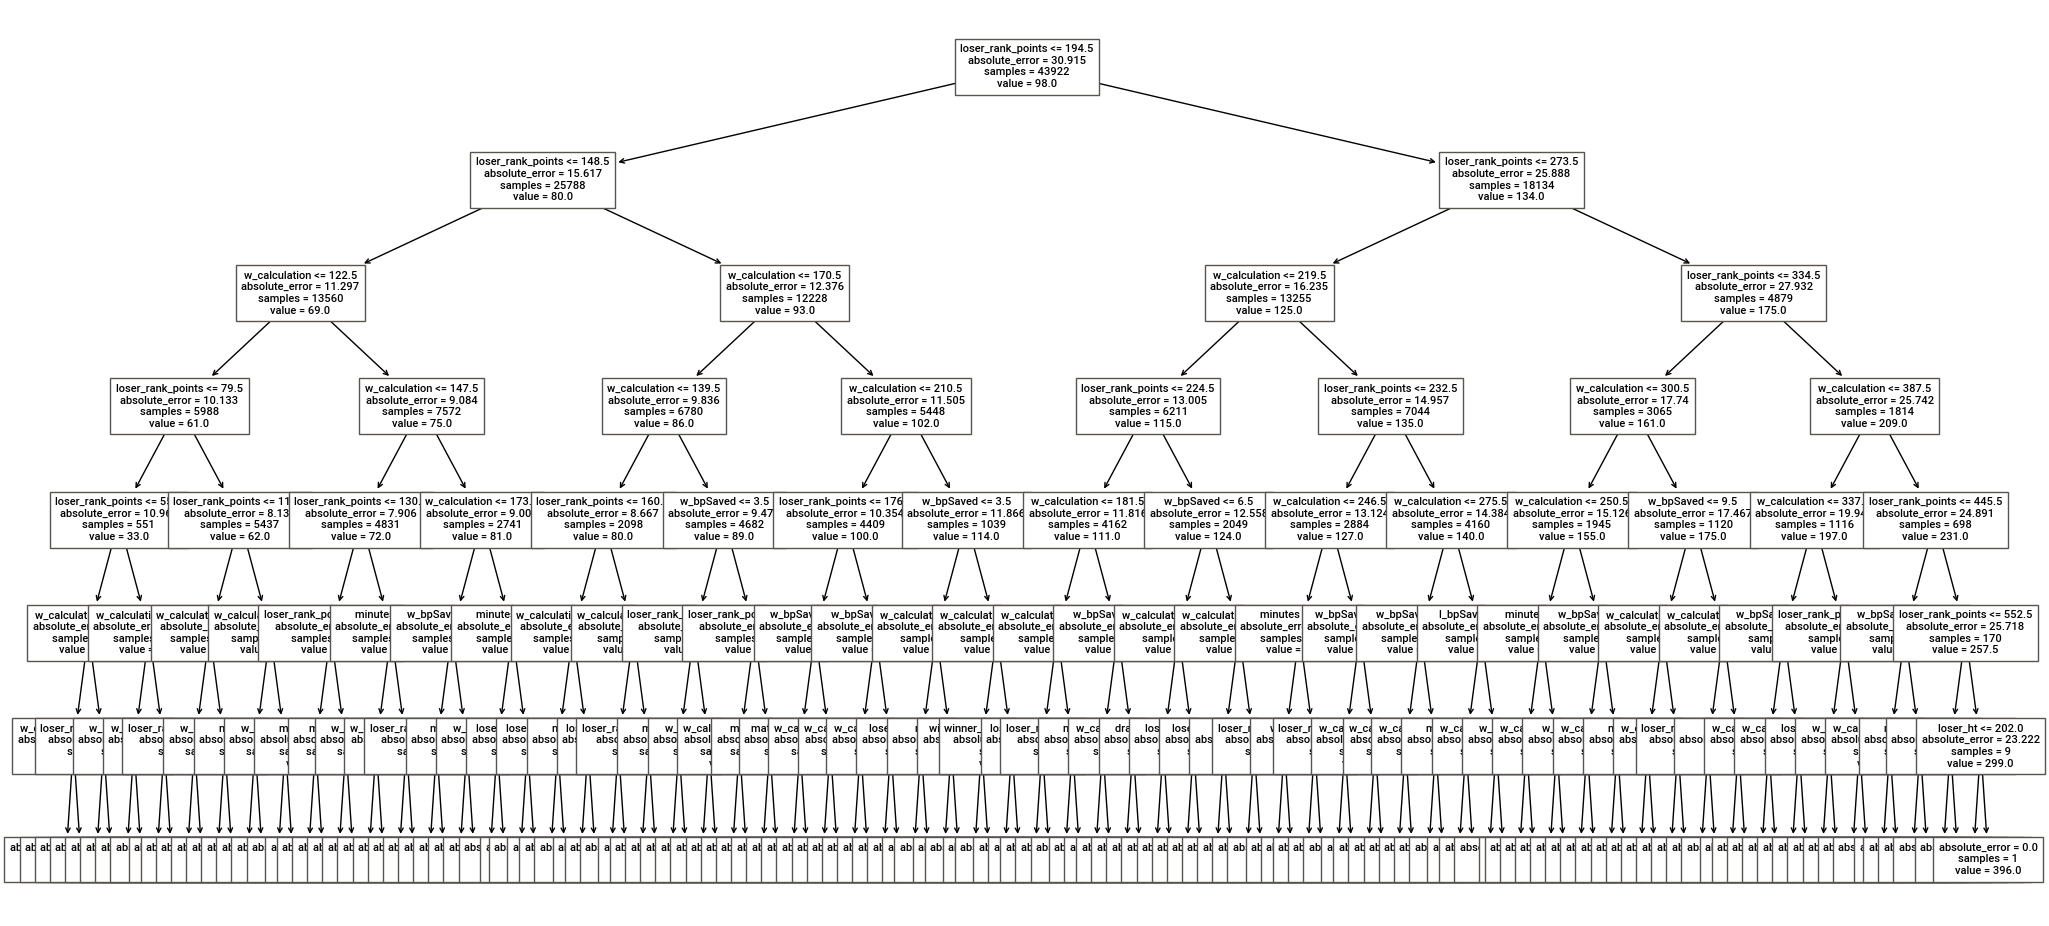

In [212]:
plt.figure(figsize=(25,12))  # set plot size (denoted in inches)
tree_plot = tree.plot_tree(dtr, fontsize=8, feature_names = df_regression.columns)

# Save Confusion Matrix image
FILE_NAME = f"best_depth_{dtr.get_depth()}_tree_{MODEL_TIMESTAMP}"

plt.savefig(TREE_PATH + FILE_NAME, dpi = resolution)

# Bibliografía

https://www.mygreatlearning.com/blog/gridsearchcv/

https://www.datatechnotes.com/2020/10/regression-example-with-decisiontreeregressor.html
